<div class="markdown-google-sans">
  <h2>Q Learning Tutorial Jupyter Notebook</h2>
  <h2>Adapted by Andy (Wen-Chung) Cheng for the Reinforcement Learning for professional course at Florida Atlantic University</h2>
</div>

# Importing packages


In [1]:
# Array math
import numpy as np

# Iteration tracking
from tqdm import tqdm

# Type hinting
from typing import Tuple

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Os traversal
import os

For rendering Greek letters in Latex for plotting

In [2]:
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams["text.latex.preamble"]  = r"\usepackage{cmbright}"
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Defining the ploting functions

## Array Index to Matplot Coords Converter

In [3]:
def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> Tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

## Maze Plotter

In [4]:
def plot_matrix(
    M: np.array,
    goal_coords: list = [],
    hole_coords: list = [],
    start_coords: list = [],
    highlight_coords: list = [],
    img_width: int = 5,
    img_height: int = 5,
    title: str = None,
    filename: str = None,
    ) -> None:
    """
    Plots a matrix as an image.
    """
    height, width = M.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')

    for x in range(height):
        for y in range(width):
            # By default, the (0, 0) coordinate in matplotlib is the bottom left corner,
            # so we need to invert the y coordinate to plot the matrix correctly
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            # If there is a tuple of (x, y) in the hole_coords list, we color the cell salmon
            elif (x, y) in hole_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='salmon'))
            # If there is a tuple of (x, y) in the start_coords list, we color the cell yellow
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))
            # If there is a tuple of (x, y) in the highlight_coords list, we color the cell lightblue
            elif (x, y) in highlight_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightblue'))

            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

In [5]:
def plot_state_visits(
        S: np.array,
        visit_dict: dict,
        img_width: int = 5,
        img_height: int = 5,
        ):
    """
    Plots the states and colors them by the number of visits.

    The more visits a state has, the darker the color.
    """
    # Get the number of rows and columns
    n_rows, n_cols = S.shape
    # Create a new matrix to hold the number of visits
    V = np.zeros((n_rows, n_cols))
    # Iterate through the visit dictionary and update the V matrix
    for s, visits in visit_dict.items():
        # Converting the state to an array index
        s_index = np.where(S == s)

        row, col = s_index[0][0], s_index[1][0]

        V[row, col] = visits

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')

    # Ploting the matrix
    sns.heatmap(V, cmap='Blues', cbar=False, annot=True, fmt='.0f', ax=ax)
    plt.show()

## Policy Plotter

In [6]:
# Defining the ploting function for the policy
def plot_policy(
        S: np.ndarray,
        policy: dict,
        goal_coords: tuple,
        wall_coords: list,
        start_coords: tuple,
        optimal_policy_path: list,
        title: str,
        img_width: int = 6,
        img_height: int = 6
        ):
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')
    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the hole_coords list, we color the cell gray
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell yellow
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))

            else:
                try:
                    # If there is a tuple of (x, y) in the start_coords list, we color the cell green
                    if (x, y) in start_coords:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

                        # Adding the arrows to the plot
                        if 0 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                        if 1 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                        if 2 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                        if 3 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)

                    elif (x, y) in optimal_policy_path:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightblue'))

                        # Adding the arrows to the plot
                        if 0 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                        if 1 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                        if 2 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                        if 3 == policy[S[x, y]]:
                            plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)
                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Current x and y: {x}, {y}")

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

    plt.show()

## Q Table Plotter

In [7]:
# Defining the ploting function for the policy
def plot_Q_Table(
        S: np.ndarray,
        Q: np.ndarray,
        goal_coords: tuple,
        wall_coords: list,
        start_coords: tuple,
        title: str,
        img_width: int = 6,
        img_height: int = 6,
        filename: str = None
        ):
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')
    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the hole_coords list, we color the cell gray
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell yellow
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))

            else:
                try:
                    # If there is a tuple of (x, y) in the start_coords list, we color the cell green
                    if (x, y) in start_coords:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))


                    plt.arrow(matplot_x, matplot_y, 0, 0.2, head_width = 0.05, head_length = 0.05)
                    ax.annotate(f"{Q[S[x, y]][0]:.2f}", xy=(matplot_x, matplot_y + 0.5), ha='center', va='top')

                    plt.arrow(matplot_x, matplot_y, 0, -0.2, head_width = 0.05, head_length = 0.05)
                    ax.annotate(f"{Q[S[x, y]][1]:.2f}", xy=(matplot_x, matplot_y - 0.5), ha='center', va='bottom')

                    plt.arrow(matplot_x, matplot_y, -0.2, 0, head_width = 0.05, head_length = 0.05)
                    ax.annotate(f"{Q[S[x, y]][2]:.2f}", xy=(matplot_x - 0.5, matplot_y), ha='left', va='center')

                    plt.arrow(matplot_x, matplot_y, 0.2, 0, head_width = 0.05, head_length = 0.05)
                    ax.annotate(f"{Q[S[x, y]][3]:.2f}", xy=(matplot_x + 0.5, matplot_y), ha='right', va='center')

                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Current x and y: {x}, {y}")

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

In [8]:
# Defining the ploting function for the policy
def plot_V_Table(
        S: np.ndarray,
        Q: np.ndarray,
        goal_coords: tuple,
        wall_coords: list,
        start_coords: tuple,
        title: str,
        img_width: int = 6,
        img_height: int = 6,
        filename: str = None
        ):
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_height))
    ax = fig.add_subplot(111, aspect='equal')
    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # If there is a tuple of (x, y) in the hole_coords list, we color the cell gray
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))

            # If there is a tuple of (x, y) in the goal_coords list, we color the cell yellow
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))

            else:
                try:
                    # If there is a tuple of (x, y) in the start_coords list, we color the cell green
                    if (x, y) in start_coords:
                        ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))


                    ax.annotate(f"{max(Q[S[x, y]]):.2f}", xy=(matplot_x, matplot_y), ha='center', va='center')

                    # Adding the arrows to the plot
                    if 0 == np.argmax(Q[S[x, y]]):
                        plt.arrow(matplot_x, matplot_y + 0.1, 0, 0.3, head_width = 0.05, head_length = 0.05)
                    if 1 == np.argmax(Q[S[x, y]]):
                        plt.arrow(matplot_x, matplot_y - 0.1, 0, -0.3, head_width = 0.05, head_length = 0.05)
                    if 2 == np.argmax(Q[S[x, y]]):
                        plt.arrow(matplot_x - 0.1, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                    if 3 == np.argmax(Q[S[x, y]]):
                        plt.arrow(matplot_x + 0.1, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)

                except Exception as e:
                    print(f"Error: {e}")
                    print(f"Current x and y: {x}, {y}")

    offset = .5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)

    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

# The agent

The agent will be an object created by the class `Agent`. All the uptades of the q table will be done internally in the agent object.

In [12]:
# steps to goal plot
# add comment about where to add training script


class Agent:
    def __init__(
        self,
        nrow_maze: int,
        ncol_maze: int,
        actions: list = [0, 1, 2, 3],
        rewards: dict = {
            'step': -1,
            'wall': -10,
            'goal': 10,
        },
        gamma: float = 0.9,
        alpha: float = 0.1,
        epsilon: float = 0.1,
        seed: int = 42,
        ) -> None:
        """
        Creates an agent for the maze environment.

        Parameters
        ----------
        nrow_maze : int
            The number of rows in the maze.
        ncol_maze : int
            The number of columns in the maze.
        actions : list, optional
            A list of actions that the agent can take. The default is [0, 1, 2, 3].
            0: Up
            1: Down
            2: Left
            3: Right
        rewards : dict, optional
            A dictionary of rewards for the agent. The default is {'step': -1, 'wall': -10, 'goal': 10}.
        gamma : float, optional
            The discount factor. The default is 0.9.
        alpha : float, optional
            The learning rate. The default is 0.1.
        epsilon : float, optional
            The exploration rate. The default is 0.1.
        seed : int, optional
            The seed for the random generator. The default is 42.
        """
        self.nrow_maze = nrow_maze
        self.ncol_maze = ncol_maze
        self.rewards = rewards
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.seed = seed
        self.actions = actions

        # By default, the starting index is 0 0
        self.start_state = 0

        # By default, the steps to goal is 0
        self.steps_to_goal = 0

        # Initialize an empty list of steps to goals for all episodes
        self.list_steps_to_goals = []

        # By default, the goal index is the last index
        self.goal_state = nrow_maze * ncol_maze - 1

        # Creating the random generator with a fixed seed
        self.random_generator = np.random.default_rng(seed)

        # Creating the maze; We will denote it internaly as S
        self.init_S_table()

        # Initiating the Q-table
        self.init_Q_table()

        # Saving the initial past_action and past_state
        self.past_action = None
        self.past_state = None

        # Creating the action name dictionary
        self.action_name_dict = {
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right',
        }

        # Counter for the number of times our agent has seen the terminal state
        self.num_goal_reached = 0

        # Counter for each state and how many times the agent visited each
        self.state_visit_counter = {}

        # Empty dictionary of states visition paths
        self.state_visit_paths = {}

        # Empty dictionary of Q values
        self.Q_dict = {}

        # Placeholder for the current episode of learning
        self.current_episode = 0


        # Defining the path to intermediate images
        self.path_to_images_V = "q-learning-V-Table_Progress"

        # Defining the path to intermediate images
        self.path_to_images_Q = "q-learning-Q-Table_Progress"

    def increment_state_visit(self, state) -> None:
        """
        Increments the state visit counter for the state.
        """
        if state in self.state_visit_counter:
            self.state_visit_counter[state] += 1
        else:
            self.state_visit_counter[state] = 1

    def get_most_recent_action(self) -> str:
        """
        Returns the name of the most recent action.
        """
        return self.action_name_dict[self.past_action]

    def init_S_table(self):
        """
        Creates an internal S table where the rows of the table are
        the states and the columns are the actions.
        """
        self.S = np.arange(0, self.nrow_maze * self.ncol_maze).reshape(self.nrow_maze, self.ncol_maze)

    def init_Q_table(self):
        """
        Creates an internal q table where the rows of the table are
        the states and the columns are the actions.
        """
        self.Q = np.zeros((self.S.size, len(self.actions)))

    def init_reward_dict(self):
        """
        Creates a dictionary where the keys are the states and the values are the rewards for transitioniting to that state.
        """
        if self.rewards.get('step') is None:
            raise ValueError("You must specify a reward for taking a step.")
        else:
            self.reward_dict = {s: self.rewards['step'] for s in self.S.flatten()}

        if self.rewards.get('goal') is None:
            raise ValueError("You must specify a reward for reaching the goal state.")
        else:
            self.reward_dict[self.goal_state] = self.rewards['goal']

        if self.rewards.get('wall') is not None:
            # Setting the reward for the wall states
            for wall_state in self.wall_states:
                self.reward_dict[wall_state] = self.rewards['wall']

    def init_maze(self, maze_density: int = None):
        """
        Creates an array of states in a maze environment.

        Returns
        -------
        maze : np.array
            A 2D array of states in a maze environment.
        wall_coords : list
            A 1D array of wall states in the maze environment.
        start_coords: tuple
            A tuple of start coordinates in the maze environment.
        goal_coords: tuple
            A tuple of goal coordinates in the maze environment.
        """
        # If maze_density is None we will create walls in 20% of the maze
        if maze_density is None:
            maze_density = int(self.nrow_maze * self.ncol_maze * 0.2)

        # Creating the wall states
        wall_states = self.random_generator.choice(range(1, self.nrow_maze * self.ncol_maze), size=maze_density, replace=False)

        # Getting the list of wall coordinates
        wall_coords = [self.get_state_coords(s) for s in wall_states]

        # Generating a starting state from the states that are NOT walls
        start_state = self.random_generator.choice(np.setdiff1d(self.S, wall_states))

        # Getting the starting coordinates
        start_coords = self.get_state_coords(start_state)

        # Generating a goal state from the states that are NOT walls and NOT the starting state
        goal_state = self.random_generator.choice(np.setdiff1d(np.setdiff1d(self.S, wall_states), start_state))

        # Getting the goal coordinates
        goal_coords = self.get_state_coords(goal_state)

        # Saving the wall coordinates, start coordinates, and goal coordinates
        self.wall_coords = wall_coords
        self.start_coords = [start_coords]
        self.goal_coords = [goal_coords]

        # Saving the indexes for the wall, start and goal states
        self.wall_states = wall_states
        self.start_state = start_state
        self.goal_state = goal_state

        # Initiating the reward dictionary
        self.init_reward_dict()

        # Initiating the agent
        self.init_agent()

    def get_state_index(self, row: int, col: int) -> int:
        """
        Returns the state index given the state coordinates.

        An inverse function of get_state_coords()
        """
        if (row < 0 or row >= self.nrow_maze or col < 0 or col >= self.ncol_maze):
            return -1
        else:
            return self.S[row][col]

    def get_state_coords(self, s) -> tuple:
        """
        Returns the state coordinates given the state index
        """
        s_index = np.where(self.S == s)
        if len(s_index[0]) == 0:
            return -1, -1

        return s_index[0][0], s_index[1][0]

    def get_action(
            self,
            ) -> int:
        """
        Returns a random action from the set of actions

        The actions are:
        0: up
        1: down
        2: left
        3: right
        """
        return self.random_generator.choice(self.actions)

    def argmax(self, q_values: np.array):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.random_generator.choice(ties)

    def get_greedy_action(self, state: int) -> int:
        """
        Returns the greedy action given the current state
        """
        # Getting the q values for the current state
        q_values = self.Q[state]

        # Getting the greedy action
        greedy_action = self.argmax(q_values)

        # Returning the greedy action
        return greedy_action

    def get_epsilon_greedy_action(self, state: int) -> int:
        """
        Returns an epsilon greedy action
        """
        if self.random_generator.random() < self.epsilon:
            return self.get_action()
        else:
            return self.get_greedy_action(state)

    # Logging of the agent paths
    def log_agent_move(self, state: int):
        """
        Logs the agent's move
        """
        if self.state_visit_paths.get(self.current_episode, None) is None:
            self.state_visit_paths[self.current_episode] = [state]
        else:
            self.state_visit_paths[self.current_episode].append(state)



    def update_Q_table(self, new_state: int):
        """
        Write your own code here to update the Q table
        """



    def get_next_state(self, s: int, action: int) -> int:
        """
        Given the current state and the current action, returns the next state index
        """
        # Getting the state coordinates
        s_row, s_col = self.get_state_coords(s)

        # Setting the boolean indicating that we have reached the terminal state
        reached_terminal = False

        # Getting the next state
        next_state = -1
        if action == 0:
            next_state = self.get_state_index(s_row - 1, s_col)
        elif action == 1:
            next_state = self.get_state_index(s_row + 1, s_col)
        elif action == 2:
            next_state = self.get_state_index(s_row, s_col - 1)
        elif action == 3:
            next_state = self.get_state_index(s_row, s_col + 1)

        # If next_state is a wall or the agent is out of bounds, we will stay in the same state
        if (next_state == -1) or (next_state in self.wall_states):
            return s, reached_terminal

        # Incrementing the number of times we have visited the next state
        self.increment_state_visit(next_state)

        # If next_state is the goal state, we will return to the starting state
        if next_state == self.goal_state:
            # Incrementing the number of times our agent has reached the goal state
            self.num_goal_reached += 1
            reached_terminal = True

        # Returning the next state
        return next_state, reached_terminal

    def init_agent(self):
        """
        We will set the past state and past action as the starting state and action
        """
        # Setting the previous state as the starting state
        self.past_state = self.start_state
        self.past_action = self.get_epsilon_greedy_action(self.past_state)
        self.num_goal_reached = 0


    def save_steps_to_goal_for_current_episode(self):
        """
        Write your own code here to save the steps to goal for current episode
        """




    def terminal_step(self, new_state: int):
        """
        Updates the agent one last time and resets the agent to the starting position
        """
        # Updating the Q table
        self.update_Q_table(new_state)

        # Resetting the agent
        self.past_state = self.start_state
        self.past_action = self.get_epsilon_greedy_action(self.past_state)


        # save the steps taken to reach the goal for this episode, and reset steps to goal to 0 for next episode
        self.save_steps_to_goal_for_current_episode()
        self.steps_to_goal = 0

        # Incrementing the number of episodes
        self.current_episode += 1

    def move_agent(self):
        """
        The function that moves the agent to the next state
        """
        # Getting the next state
        next_state, reached_terminal = self.get_next_state(self.past_state, self.past_action)

        # Adding the next state to the path
        self.log_agent_move(next_state)

        # Updating the Q table
        if not reached_terminal:
            # Checking if the past_state is the same as the next_state; If that is true, it means our agent hit a wall
            # or went out of bounds
            if self.past_state != next_state:
                self.update_Q_table(next_state)

            # Setting the past_state as the next_state
            self.past_state = next_state

            # Getting the next action
            self.past_action = self.get_epsilon_greedy_action(self.past_state)

            # add 1 step
            self.steps_to_goal += 1

        else:
            # add 1 step
            self.steps_to_goal += 1
            self.terminal_step(next_state)

    def train_episodes(self, num_episodes: int):
        """
        Function that trains the agent for one episode
        """
        # Calculating the episode number to end the training
        end_episode = self.current_episode + num_episodes - 1

        # Moving the agent until we reach the goal state
        while self.current_episode != end_episode:

            print(f"Episode {self.current_episode}")

            self.move_agent()

    def create_policy(self):
        """
        Creates a policy dictionary where the key is the state and the value is the action
        based on the Q table
        """
        # Creating the policy dictionary
        self.policy = {}

        # Looping through the states
        for state in range(self.S.size):
            # Getting the greedy action
            greedy_action = self.argmax(self.Q[state])

            # Adding the state and action to the policy dictionary
            self.policy[state] = greedy_action

    def create_optimal_policy_path(self):
        """
        Creates the path of the optimal policy, starting from the starting state
        """
        # Creating the policy path
        self.optimal_policy_path = [self.start_state]
        self.optimal_policy_path_coords = [self.get_state_coords(self.start_state)]

        # Getting the current state
        current_state = self.start_state

        # Looping through the states
        while current_state != self.goal_state:
            # Getting the next state
            next_state, _ = self.get_next_state(current_state, self.policy[current_state])

            # Adding the next state to the path
            self.optimal_policy_path.append(next_state)
            self.optimal_policy_path_coords.append(self.get_state_coords(next_state))

            # Setting the current state as the next state
            current_state = next_state

# Agent learning

First, let us create the agent object and initiate the maze environment for it.

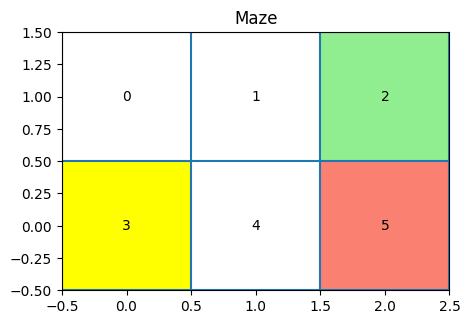

In [10]:
agent = Agent(
    nrow_maze=2,
    ncol_maze=3,
    seed=0,
    rewards={'step': 0, 'goal': 10}
)

# Initiating the maze
agent.init_maze(maze_density=1)

# Ploting the maze
plot_matrix(agent.S, goal_coords=agent.goal_coords, hole_coords=agent.wall_coords, start_coords=agent.start_coords, title="Maze")

Display the initial Q table

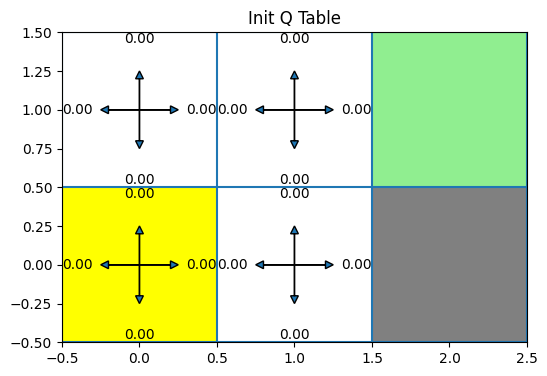

In [11]:
plot_Q_Table(
    S=agent.S,
    Q=agent.Q,
    goal_coords=agent.goal_coords,
    wall_coords=agent.wall_coords,
    start_coords=agent.start_coords,
    title="Init Q Table"
    )

# References

1.   https://github.com/Eligijus112/rl-snake-game
2.   Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.




